# Training an SGDClassifier model using different strategies for dealing with an imbalanced dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, classification_report)
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
import os

In [3]:
#Loading data

#Defining BASE_PATH
BASE_PATH = os.getenv("/Users/carlos/Desktop/CURSOS/Anyone AI/Credit-Risk-App/dataset/", "/Users/carlos/Desktop/CURSOS/Anyone AI/Credit-Risk-App/dataset/")

train_file_path = os.path.join(BASE_PATH, "X_train_data.csv")
y_train_file_path = os.path.join(BASE_PATH, "y_train_data.csv")
val_file_path = os.path.join(BASE_PATH, "X_val_data.csv")
y_val_path = os.path.join(BASE_PATH, "y_val_data.csv")

train_df = pd.read_csv(train_file_path)

y_train_df = pd.read_csv(y_train_file_path)
y_train = y_train_df['TARGET_LABEL_BAD']
y_train = y_train.to_numpy()

val_df = pd.read_csv(val_file_path)

y_valid_df = pd.read_csv(y_val_path)
y_valid = y_valid_df['TARGET_LABEL_BAD']
y_valid = y_valid.to_numpy()


=== Default SGDClassifier Performance ===
Accuracy: 0.5224
Precision: 0.32358837287003006
Recall: 0.7271021021021021
F1 Score: 0.4478612716763006
ROC-AUC: 0.6185584951090677
Confusion Matrix:
 [[3287 4049]
 [ 727 1937]]
                              0   Weights
0           RESIDENCIAL_BOROUGH  3.330637
1              RESIDENCIAL_CITY  1.396520
2                      AGE_18.0  1.341164
3                      AGE_63.0  1.141142
4                      AGE_20.0  1.080690
5   RESIDENCIAL_PHONE_AREA_CODE  1.054961
6                      AGE_95.0  0.985592
7      MONTHS_IN_RESIDENCE_65.0  0.945053
8                      AGE_82.0  0.919356
9                      AGE_24.0  0.918273
10         RESIDENCIAL_STATE_AP  0.911571
11                     AGE_70.0  0.901836
12                     AGE_25.0  0.897236
13                     AGE_84.0  0.883642
14                     AGE_67.0  0.860270
15                     AGE_31.0  0.850107
16                     AGE_30.0  0.849007
17                     A

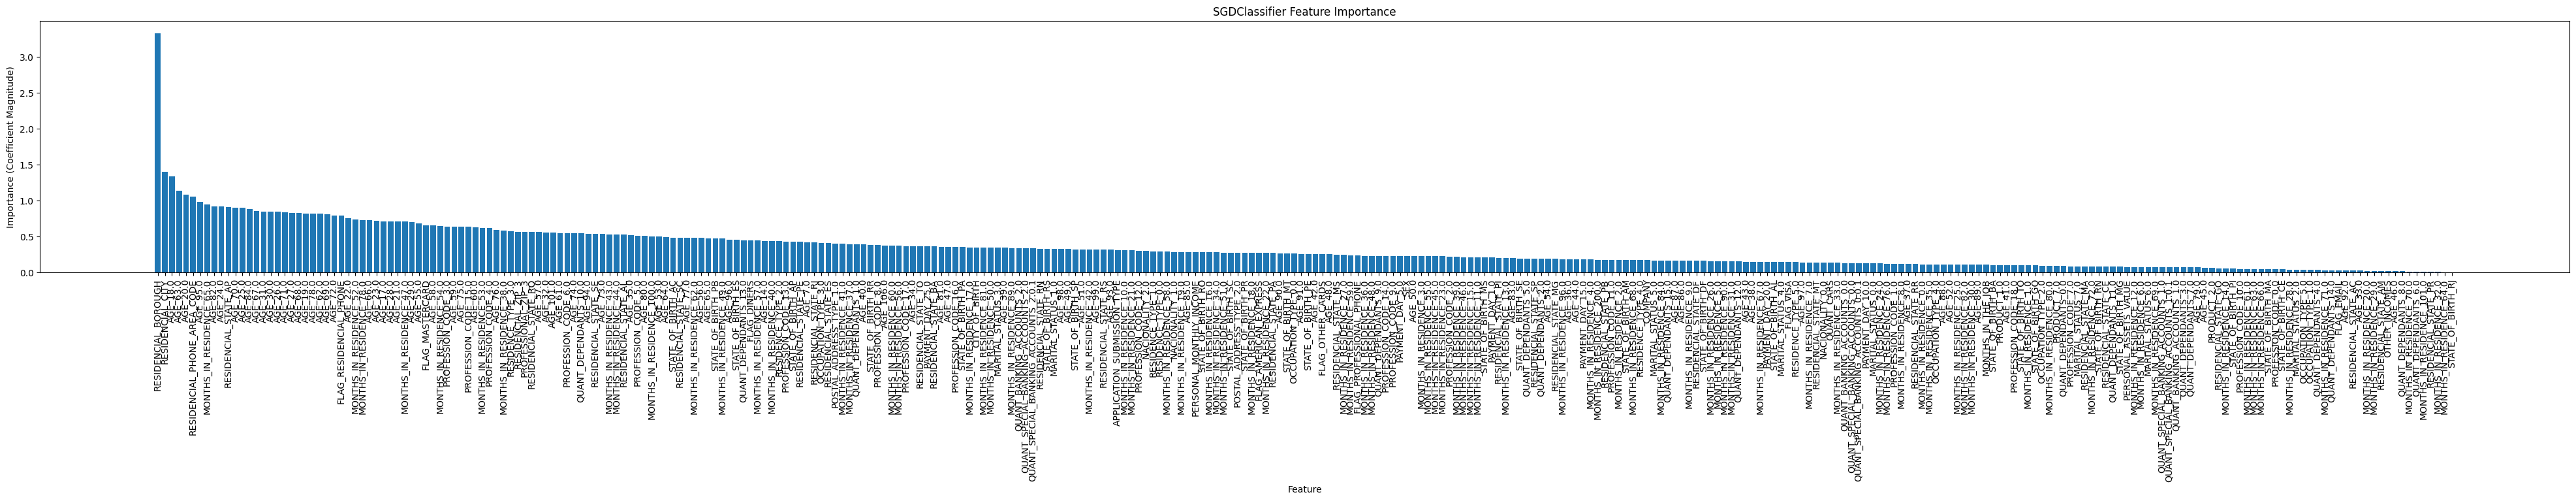

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END alpha=0.0002782559402207126, eta0=0.1, learning_rate=optimal, max_iter=10000, penalty=l1; total time=   1.9s
[CV] END alpha=0.0002782559402207126, eta0=0.1, learning_rate=optimal, max_iter=10000, penalty=l1; total time=   1.4s
[CV] END alpha=0.0002782559402207126, eta0=0.1, learning_rate=optimal, max_iter=10000, penalty=l1; total time=   1.7s
[CV] END alpha=0.0002782559402207126, eta0=0.1, learning_rate=optimal, max_iter=10000, penalty=l1; total time=  44.3s
[CV] END alpha=0.0002782559402207126, eta0=0.1, learning_rate=optimal, max_iter=10000, penalty=l1; total time=  50.8s
[CV] END alpha=0.046415888336127774, eta0=0.1, learning_rate=constant, max_iter=10000, penalty=l2; total time=   0.4s
[CV] END alpha=0.046415888336127774, eta0=0.1, learning_rate=constant, max_iter=10000, penalty=l2; total time=   0.3s
[CV] END alpha=0.046415888336127774, eta0=0.1, learning_rate=constant, max_iter=10000, penalty=l2; total time=  

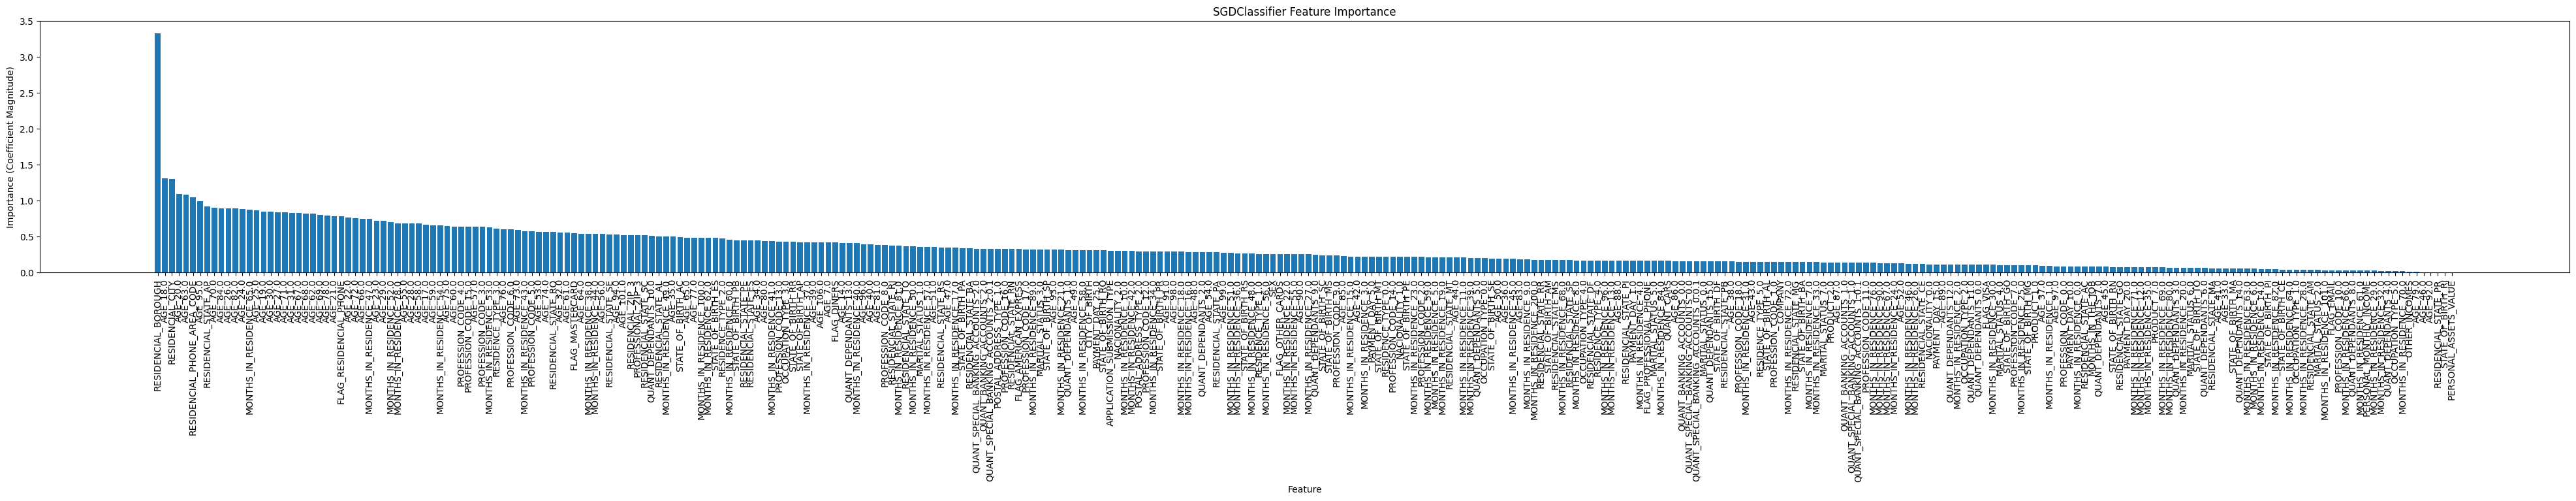

In [30]:
# Handling Imbalanced Data with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(train_df, y_train)

# Train SGDClassifier (Hinge Loss = SVM)
sgd_svm = SGDClassifier(loss="hinge", class_weight="balanced", random_state=42, n_jobs=-1, max_iter=10000)
sgd_svm.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = sgd_svm.predict(val_df)
y_prob = sgd_svm.decision_function(val_df)  # Similar to predict_proba[:, 1]

# Performance Metrics
print("=== Default SGDClassifier Performance ===")
print("Accuracy:", accuracy_score(y_valid, y_pred))
print("Precision:", precision_score(y_valid, y_pred))
print("Recall:", recall_score(y_valid, y_pred))
print("F1 Score:", f1_score(y_valid, y_pred))
print("ROC-AUC:", roc_auc_score(y_valid, y_prob))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred))

# Feature Importance (Absolute Coefficients)
feature_importance = np.abs(sgd_svm.coef_).flatten()
feature_names = train_df.columns
sorted_indices = np.argsort(feature_importance)[::-1]

df_pandas_index = pd.DataFrame(np.array(feature_names)[sorted_indices])
df_np_array = pd.DataFrame(feature_importance[sorted_indices], columns=['Weights'])
df_weights = pd.concat([df_pandas_index, df_np_array], axis=1)
print(df_weights.head(20))

plt.figure(figsize=(50, 5))
plt.bar(range(len(feature_importance)), feature_importance[sorted_indices], align='center')
plt.xticks(range(len(feature_importance)), np.array(feature_names)[sorted_indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance (Coefficient Magnitude)")
plt.title("SGDClassifier Feature Importance")
plt.show()

# ============================
#  Hyperparameter Tuning
# ============================
param_dist = {
    "alpha": np.logspace(-4, 0, 10),  # Regularization strength
    "penalty": ["l1", "l2"],  # L1 = Lasso, L2 = Ridge
    "max_iter": [5000, 10000],
    "learning_rate": ["optimal", "adaptive", "constant"],
    "eta0": np.logspace(-3, -1, 5),
}

random_search = RandomizedSearchCV(SGDClassifier(loss="hinge", class_weight="balanced", random_state=42, n_jobs=-1),
                                   param_distributions=param_dist, n_iter=20, cv=5, scoring="f1", verbose=2, random_state=42)

random_search.fit(X_train_resampled, y_train_resampled)

# Best Model
best_sgd_svm = random_search.best_estimator_

# Predictions with Tuned Model
y_pred_tuned = best_sgd_svm.predict(val_df)
y_prob_tuned = best_sgd_svm.decision_function(val_df)

# 📊 Performance Metrics (Tuned Model)
print("\n=== Tuned SGDClassifier Performance ===")
print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_valid, y_pred_tuned))
print("Precision:", precision_score(y_valid, y_pred_tuned))
print("Recall:", recall_score(y_valid, y_pred_tuned))
print("F1 Score:", f1_score(y_valid, y_pred_tuned))
print("ROC-AUC:", roc_auc_score(y_valid, y_prob_tuned))

# Confusion Matrix (Tuned Model)
print("Confusion Matrix (Tuned Model):\n", confusion_matrix(y_valid, y_pred_tuned))

#===========================================
# Feature Importance (Absolute Coefficients)
feature_importance = np.abs(best_sgd_svm.coef_).flatten()
feature_names = train_df.columns
sorted_indices = np.argsort(feature_importance)[::-1]

df_pandas_index = pd.DataFrame(np.array(feature_names)[sorted_indices])
df_np_array = pd.DataFrame(feature_importance[sorted_indices], columns=['Weights'])
df_weights = pd.concat([df_pandas_index, df_np_array], axis=1)
print(df_weights.head(20))

plt.figure(figsize=(50, 5))
plt.bar(range(len(feature_importance)), feature_importance[sorted_indices], align='center')
plt.xticks(range(len(feature_importance)), np.array(feature_names)[sorted_indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance (Coefficient Magnitude)")
plt.title("SGDClassifier Feature Importance")
plt.show()